In [1]:
import numpy as np

def RemoveFrom(l, xs):
    for x in xs:
        try:
            l.remove(x)
        except:
            raise Exception(x)

class Network:
    def __init__(self, edges, dists = None, symmetry = False):
        """
        edge dict:
            key: index of node, int
            val: indices of linked nodes, list of ints
        weight dict:
            key: index of node, int
            val: weights of linked nodes, array of floats
        neighbours dict:
            key: index of node, int
            val: list of lists of ints
        """
        self.nodes = list(edges.keys())
        self.size = len(self.nodes)
        self.edges = edges
        if symmetry:
            for key in self.edges.keys():
                for node in self.edges[key]:
                    if key not in self.edges[node]:
                        self.edges[node].append(key)
        if not (dists is None):
            self.dists = dists

        else:
            # init equal weights
            self.dists = {key: np.array([1 for _ in value]) for key, value in edges.items()}
        self.neighbours, self.neighbour_weights = {},{}
        for key, value in edges.items():
            neighbours, neighbour_weights = self.ComputeNeighbours(key)
            self.neighbours[key] = neighbours
            self.neighbour_weights[key] = neighbour_weights
        self.adj_mat = self.AdjMatrix()
        self.w_mats = self.WeightMatrix()

    def AdjMatrix(self):
        """
        return the adjacency matrix
        """
        mat = np.zeros((self.size,self.size))
        for i in range(self.size):
            mat[([i for j in self.edges[i]],[j for j in self.edges[i]])] = 1
        return mat


    def ComputeNeighbours(self, node):
        neighbours = [self.edges[node]]
        neighbour_weights = [1/self.dists[node]/sum(1/self.dists[node])]
        nodes_left = self.nodes[:] # nodes that are not yet connected to this node
        RemoveFrom(nodes_left,neighbours[-1]+[node])
        prev_dists = self.dists[node]
        while True:
            stage_neighbours = []
            stage_dists = {}
            for i in range(len(neighbours[-1])):
                # for each stage_r-1 neighbour, find its neighbours
                prev_neighbour = neighbours[-1][i]
                for j in range(len(self.edges[prev_neighbour])):
                    stage_neighbour = self.edges[prev_neighbour][j]
                    if (stage_neighbour in nodes_left) & (stage_neighbour!=node):
                    # if the stage-r neighbour is not in previous stage(still left unconnected) and is not self
                        if not (stage_neighbour in stage_neighbours):
                        # if stage neighbour not added to stage-r neighbourhood, add to neighbourhood
                        # and add dist(node to stage neighbour) = min_dist(node to prev neighbour)+dist(prev neighbour to stage neighbour)
                            stage_neighbours.append(stage_neighbour)
                            stage_dists[stage_neighbour] = [prev_dists[i]+self.dists[prev_neighbour][j]]
                        else:
                        # add dist(...) = ....
                            stage_dists[stage_neighbour].append(prev_dists[i]+self.dists[prev_neighbour][j])
            if len(stage_neighbours) == 0:
                # if no new neighbours detected, end and return
                return neighbours, neighbour_weights
            # for each stage-r neighbour, find the min_dist(node to stage neighbour)
            stage_dists = np.array([min(stage_dists[stage_neighbour]) for stage_neighbour in stage_neighbours])
            RemoveFrom(nodes_left, stage_neighbours) # update nodes not connected
            neighbours.append(stage_neighbours)
            neighbour_weights.append(1/stage_dists/sum(1/stage_dists))
            prev_dists = stage_dists

    def WeightMatrix(self):
        max_stage = max([len(self.neighbours[node]) for node in self.nodes])
        w_mats = [np.identity(self.size)]
        for r in range(max_stage):
            mat = np.zeros((self.size,self.size))
            for i in range(self.size):
                if len(self.neighbours[i]) > r:
                    mat[([i for j in self.neighbours[i][r]],[j for j in self.neighbours[i][r]])] = 1
            w_mats.append(np.divide(mat, np.sum(mat,axis=0), out=np.zeros_like(mat), where=np.sum(mat,axis=0)!=0))
        return np.array(w_mats)

n8_14=Network({0:[1,3,4],1:[0,6],2:[3,4],3:[2,4],4:[0,2],5:[0,1,4],6:[3],7:[4,6,2]},symmetry=True)
n8_7=Network({0:[1],1:[0],2:[4],3:[4],4:[2],5:[0,1],6:[3],7:[6]},symmetry=True)
n8_7_2=Network({0:[6,7],1:[3,4],2:[5],3:[1,5],4:[1,6],5:[2,3],6:[0,4],7:[0]},symmetry=True)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#from network import *
#from GNAR import *

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [16]:
class NetworkModel:
    def __init__(self, alpha_order, beta_order, intercept=True, global_intercept=False):
        self.beta_order = beta_order
        self.intercept = intercept
        self.global_intercept = global_intercept
        if isinstance(alpha_order,int):
            self.alpha_order = alpha_order
            self.alpha_orders = [1 for _ in range(alpha_order)]
        else:
            self.alpha_order = len(alpha_order)
            self.alpha_orders = alpha_order # alpha_orders is [1,0,0,1,...]; alpha order is max time lag

    """
    def transformVTS(self, vts):
        # shape of X: n*p, col_1:x_t-1; col_2:2+beta_order_1: weighted t-1 stage-r neighbours, ...
        X = np.zeros(((len(vts)-self.alpha_order)*self.network.size,self.coef_order))
        for t in range(1,self.alpha_order+1):
            #alpha_t
            if self.coef_index[2*t-2] != 0 and self.coef_index[2*t-2] != self.coef_index[2*t-3]:
                X[:,self.coef_index[2*t-2]-1] = vts[self.alpha_order-t:-t,:].flatten("F")
            for i in range(self.coef_index[2*t-2], self.coef_index[2*t-1]):
                #each beta_t
                stage = i - self.coef_index[2*t-2]
                #for each node, compute weighted t-1 stage-r neighbours, and concat them to one vertical column
                X[:,i] = np.concatenate([vts[self.alpha_order-t:-t,self.network.neighbours[node][stage]].
                                         dot(self.network.neighbour_weights[node][stage])
                                       if len(self.network.neighbours[node]) > stage
                                       else [0 for i in range(vts.shape[0]-alpha_order)]
                                       for node in self.network.nodes])
        if self.intercept:
            if self.global_intercept:
                X = np.hstack((X,np.ones((X.shape[0],1))))
            else:
                X = np.hstack((X,np.repeat(np.identity(self.network.size), len(vts)-self.alpha_order, axis=0)))
        return X
        """

    def transformVTS(self,vts):
        X = []
        for t in range(self.alpha_order):
            X.append(np.transpose(vts[self.alpha_order-t-1:-t-1,:]@self.network.w_mats[1-self.alpha_orders[t]:1+self.beta_order[t]],axes=(1,2,0)).reshape(
                (-1,self.alpha_orders[t]+self.beta_order[t]),order="F")) #optimize this
        X = np.hstack(X)
        if self.intercept:
            if self.global_intercept:
                X = np.hstack((X,np.ones((X.shape[0],1))))
            else:
                X = np.hstack((X,np.repeat(np.identity(self.network.size), len(vts)-self.alpha_order, axis=0)))
        return X

    def return_coef(self, t, type="all"):
        if type=="alpha":
            if self.coef_index[2*t-2] != 0 and self.coef_index[2*t-2] != self.coef_index[2*t-3]:
                return self.coefs[self.coef_index[2*t-2]-1]
            else:
                return 0
        elif type == "beta":
            return self.coefs[self.coef_index[2*t-2]:self.coef_index[2*t-1]]
        elif type == "all":
            return self.coefs[self.coef_index[2*t-2]-1:self.coef_index[2*t-1]]

    def AIC(self):
        return 2*len(self.coefs)-2*self.loglik()
    def BIC(self):
        return len(self.coefs)*np.log(len(self.y))-2*self.loglik()
    def group_NTS(self, network, vts, size):
        self.network = network
        X = self.transformVTS(vts)
        T,n = len(vts),self.network.size
        self.k = int(np.ceil((T-self.alpha_order)/size))
        G = np.zeros(((T-self.alpha_order)*n,self.k*X.shape[1]))
        for i in range(self.k-1):
            for j in range(i+1):
                G[i*size*n:(i+1)*size*n,j*X.shape[1]:(j+1)*X.shape[1]] = X[i*size*n:(i+1)*size*n,:]
        for j in range(self.k):
            G[(self.k-1)*size*n:,j*X.shape[1]:(j+1)*X.shape[1]] = X[(self.k-1)*size*n:,:]
        return G

from scipy.optimize import lsq_linear
from scipy.stats import multivariate_normal, norm
from itertools import chain, combinations


def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def min_part(xs, r):
    xs = np.sort(xs)
    part = []
    ys = []
    for x in xs:
        for y in ys:
            if abs(x-y) >= r:
                part.append(ys)
                ys = []
                break
        ys.append(x)
    part.append(ys)
    return part


class GNAR(NetworkModel):
    def __init__(self, alpha_order, beta_order, intercept=True, global_intercept=False):
        super().__init__(alpha_order, beta_order,intercept,global_intercept)
        self.coef_index = np.cumsum([[self.alpha_orders[i]]+[beta_order[i]] for i in range(self.alpha_order)])
        self.coef_order = self.coef_index[-1]

    def simulate(self, network, initial_vts, length, coefs, error_cov_mat):
        self.network = network
        l = len(initial_vts)
        vts_sim = np.zeros((length+l,self.network.size))
        vts_sim[:l,:] = initial_vts
        for i in range(length):
            vts_sim[l+i,:] = self.transformVTS(vts_sim[l+i-self.alpha_order:l+i+1,:])@coefs + multivariate_normal(
                cov=error_cov_mat).rvs(1)
        return vts_sim[len(initial_vts):]

    def loglik(self):
        return np.sum(norm.logpdf(self.y,loc=self.X@self.coefs,scale=self.sigma2**.5))

    def r2(self):
        return r2_score(self.y, self.X@self.coefs)

    def adj_r2(self):
        return 1-((1-self.r2())*(len(self.y)-1)/(len(self.y)-len(self.coefs)-1))

    def fit(self, network, vts):
        # the order of cols of vts must match the order of network nodes
        # i.e. the first vts col is the ts for the first node in the network, etc
        self.network = network
        self.vts = vts
        self.vts_end = vts[-self.alpha_order:,:]
        self.y = vts[self.alpha_order:,:].flatten("F")
        self.X = self.transformVTS(vts)
        self.coefs,self.res = np.linalg.lstsq(self.X, self.y, rcond=None)[:2]
        self.vts_fitted = np.reshape((self.X@self.coefs),(-1,network.size),"F")
        #self.sigma2 = np.sum((self.y-self.X@self.coefs)**2)/(len(self.y)-len(self.coefs)) #assuming equal error var

    def compute_cov(self,X,y,coefs):
        T = int(len(y)/self.network.size)
        residual = np.reshape((y-X@coefs),(-1,self.network.size),"F")
        res_cov_mat = residual.T@residual/T
        var_X_res = 0
        X = X[np.concatenate([np.array([i*T for i in range(self.network.size)])+t for t in range(T)])]
        y = y[np.concatenate([np.array([i*T for i in range(self.network.size)])+t for t in range(T)])]
        for i in range(self.network.size):
            for j in range(self.network.size):
                xti_xtj = np.mean([np.outer(X[i+k*self.network.size],X[j+k*self.network.size]) for k in range(T)],axis=0)
                var_X_res += res_cov_mat[i,j]*xti_xtj
        X_cov_mat = X.T@X/T
        inv_X_cov_mat = np.linalg.inv(X.T@X)*T
        coef_cov_mat = inv_X_cov_mat@var_X_res@inv_X_cov_mat/T
        inv_coef_cov_mat = X_cov_mat@np.linalg.solve(var_X_res,X_cov_mat)*T
        return coef_cov_mat,inv_coef_cov_mat

    def predict(self, length, nodes=None, vts_end =None):
        if vts_end is None:
            vts_end = self.vts_end
        vts_pred = np.zeros((length+self.alpha_order,self.network.size))
        vts_pred[:self.alpha_order,:] = vts_end
        for i in range(length):
            vts_pred[self.alpha_order+i,:] = self.transformVTS(vts_pred[i:self.alpha_order+i+1,:])@self.coefs
        if nodes is None:
            return vts_pred[self.alpha_order:,:]
        else:
            return vts_pred[self.alpha_order:,nodes]



    def return_coef(self, t, type="all"):
        if type=="alpha":
            if self.coef_index[2*t-2] != 0 and self.coef_index[2*t-2] != self.coef_index[2*t-3]:
                return self.coefs[self.coef_index[2*t-2]-1]
            else:
                return 0
        elif type == "beta":
            return self.coefs[self.coef_index[2*t-2]:self.coef_index[2*t-1]]
        elif type == "all":
            return self.coefs[self.coef_index[2*t-2]-1:self.coef_index[2*t-1]]

    def initial_fit(self,network,vts,size,level=0.05):
        self.network = network
        self.vts = vts
        self.size = size
        self.T = len(self.vts)-self.alpha_order
        self.y = vts[self.alpha_order:,:].flatten("F")
        self.X = self.transformVTS(vts)
        self.block_number = int(np.ceil(self.T/size))
        index = np.concatenate([np.arange(size)+i*self.T for i in range(self.network.size)])
        coefs_prev = lsq_linear(self.X[index], self.y[index]).x
        self.cpts_candidate = []
        for l in range(1,self.block_number):
            index = np.concatenate([np.arange(l*size,min(self.T,(l+1)*size))+i*self.T for i in range(self.network.size)])
            coefs_new = lsq_linear(self.X[index], self.y[index]).x
            coef_cov_mat,inv_coef_cov_mat = self.compute_cov(self.X[index], self.y[index],coefs_new)
            test_chi2 = np.dot((coefs_new-coefs_prev),(inv_coef_cov_mat@(coefs_new-coefs_prev)))
            p = chi2(df=len(coefs_prev)).sf(test_chi2)
            #print(p)
            #print(coef_cov_mat)
            #print(2*norm().sf(abs(coefs_new-coefs_prev)/np.array([coef_cov_mat[i,i] for i in range(len(coefs_new))])**(1/2)))
            if p<level:
                coefs_prev = coefs_new
                self.cpts_candidate.append(l*size)
        #print(self.cpts_candidate)

    def minimize(self,X,y):
        return lsq_linear(X,y).cost

    def LIC(self,cpts_subset,window,omega):
        #local information criterion
        rss = 0
        n = 0
        for cpt in self.cpts_candidate:
            if (cpt in cpts_subset):
                index_1 = np.concatenate([np.arange(cpt-window,cpt)+i*(self.T) for i in range(self.network.size)])
                index_2 = np.concatenate([np.arange(cpt,min(self.T,cpt+window))+i*(self.T) for i in range(self.network.size)])
                rss += (lsq_linear(self.X[index_1],self.y[index_1]).cost+
                lsq_linear(self.X[index_2],self.y[index_2]).cost)
                n += len(index_1) + len(index_2)
            else:
                index = np.concatenate([np.arange(cpt-window,min(self.T,cpt+window))+i*(self.T) for i in range(self.network.size)])
                rss += lsq_linear(self.X[index],self.y[index]).cost
                n += len(index)
        if omega == "AIC":
            lic = n*np.log(rss/n) + len(cpts_subset)*self.X.shape[1]*2
        elif omega == "BIC":
            lic = n*np.log(rss/n) + len(cpts_subset)*self.X.shape[1]*np.log(n)
        else:
            lic = n*np.log(rss/n) + len(cpts_subset)*self.X.shape[1]*omega
        return lic

    def local_screening(self,window,omega):
        lowest_lic = np.inf
        for cpts_subset in powerset(self.cpts_candidate):
            lic = self.LIC(cpts_subset,window,omega)
            if lic < lowest_lic:
                cpts = cpts_subset
                lowest_lic = lic
        self.cpts = cpts


    def exhaustive_search(self,window):
        partition = min_part(self.cpts,2*window)
        cpts = []
        for ts in partition:
            if len(ts) == 1:
                l,u = ts[0]-window, min(self.T,ts[0]+window)
            else:
                l,u = min(ts),max(ts)
            lowest_cost = np.inf
            for t in range(l,u):
                index_1 = np.concatenate([np.arange(l,t)+i*(len(self.vts)-self.alpha_order) for i in range(self.network.size)])
                index_2 = np.concatenate([np.arange(t,u)+i*(len(self.vts)-self.alpha_order) for i in range(self.network.size)])
                cost = lsq_linear(self.X[index_1],self.y[index_1]).cost + lsq_linear(self.X[index_2],self.y[index_2]).cost
                if cost < lowest_cost:
                    best_t = t
                    lowest_cost = cost
            cpts.append(best_t)
        self.cpts = np.array(cpts)+self.alpha_order

    def cpts_detect(self,network,vts,size,window,omega):
        self.initial_fit(network,vts,size)
        if len(self.cpts_candidate) == 0:
            return []
        self.local_screening(window, omega)
        if len(self.cpts) == 0:
            return []
        self.exhaustive_search(window)
        return self.cpts


def GNAR_sim_piecewise(networks, alpha_order, beta_order, coefs_list, intercept,global_intercept,error_cov_mat_list, length_list, burn_in = 100):
    num_piece = len(coefs_list)
    vts = np.zeros((sum(length_list)+burn_in+alpha_order,networks[0].size))
    vts[:alpha_order] = norm(loc=0).rvs(size=(alpha_order,networks[0].size))
    current_index = alpha_order
    length_list[0] += burn_in
    for l in range(num_piece):
        model = GNAR(alpha_order,beta_order,intercept, global_intercept)
        vts[current_index:current_index+length_list[l]]=model.simulate(networks[l],vts[:current_index],length_list[l],coefs_list[l],error_cov_mat_list[l])
        current_index = current_index+length_list[l]
    return vts[burn_in+alpha_order:]


def softplus(x,c=1,limit=30):
    sp = np.zeros(x.shape)
    sp[x/c>limit] = x[x>limit]
    sp[x/c<=limit] = c*np.log1p(np.exp(x[x<=limit]/c))
    return sp

import tensorflow as tf
import tensorflow_probability as tfp

def norm_tf(x, order = 1):
    return tf.math.pow(tf.reduce_sum(tf.math.pow(tf.abs(x),order)),1/order)


class NGNAR_TF(NetworkModel):
    def __init__(self, alpha_order, beta_order, intercept=True, global_intercept=True,link="softplus",seasonal=False):
        self.beta_order = beta_order
        self.intercept = intercept
        self.global_intercept = global_intercept

        if isinstance(alpha_order,int):
            self.alpha_order = alpha_order
            self.alpha_orders = [1 for _ in range(alpha_order)]
        else:
            self.alpha_order = len(alpha_order)
            self.alpha_orders = alpha_order # alpha_orders is [1,0,0,1,...]; alpha order is max time lag

        self.coef_index = np.cumsum([[self.alpha_orders[i]]+[beta_order[i]] for i in range(self.alpha_order)])
        self.coef_order = self.coef_index[-1]

        self.seasonal = seasonal #seasonal adjustment
        #self.inv =inv # controls whether the link function is applied to the vts when fitting
        if link == "softplus":
            self.link = lambda x:tf.math.softplus(x)
            self.link_np = lambda x: softplus(x)
        elif link == "identity":
            self.link = lambda x:x
            self.link_np = self.link
        elif link == "relu":
            self.link = tf.nn.relu
            self.link_np = relu

    def get_fitted(self):
        y = self.link(tf.linalg.matmul(self.X,self.coefs))
        if self.seasonal:
            return y + self.season_seq(self.t)
        else:
            return y

    def season_seq(self,t):
        # the last term is to keep the result non-neg
        return self.coefs_season[0]*tf.sin(self.coefs_season[1]*t-self.coefs_season[2])+self.coefs_season[0]

    def MSE(self):
        return tf.keras.losses.MeanSquaredError()(self.y, self.get_fitted())+self.coef_penalty()

    def r2(self):
        return r2_score(self.y, self.get_fitted())

    def adj_r2(self):
        return 1-((1-self.r2())*(len(self.y)-1)/(len(self.y)-len(self.coefs)-1))

    def loglik(self):
        return np.sum(poisson.logpmf(self.y,mu=self.y_fitted))


    def neg_loglik(self):
        return -tf.math.reduce_sum(tfp.distributions.Poisson(rate=self.get_fitted()).log_prob(self.y))+self.coef_penalty()

    #def fit_MLE(self, network, vts):
     #   """
     #   fit the NGNAR model using IWLS,
      #  only poisson distribution is implemented
      #  """
      #  glm = tfp.glm.CustomExponentialFamily(tfp.distributions.Poisson, tf.math.softplus)
      #  self.network = network

      #  self.vts_end = vts[-self.alpha_order:,:]
      #  self.y = tf.convert_to_tensor(vts[self.alpha_order:,:].flatten("F"),dtype=np.float64)
      #  self.X = tf.convert_to_tensor(self.transformVTS(vts),dtype=np.float64)
      #  self.coefs = tf.Variable(np.linalg.lstsq(self.X, self.y,None)[0])
      #  self.coefs = tfp.glm.fit(self.X,self.y,glm,self.coefs,fast_unsafe_numerics=False)[0].numpy()

    def fit_MLE(self, network, vts):
        """
        fit the NGNAR model using IWLS,
        only poisson distribution is implemented
        """
        glm = tfp.glm.CustomExponentialFamily(tfp.distributions.Poisson, tf.math.softplus)
        self.network = network

        self.vts_end = vts[-self.alpha_order:,:]
        self.y = tf.convert_to_tensor(vts[self.alpha_order:,:].flatten("F"),dtype=np.float64)
        # Transfer to GPU
        #with tf.device('/GPU:0'):
         #   self.y = tf.identity(self.y )

        self.X = tf.convert_to_tensor(self.transformVTS(vts),dtype=np.float64)
        # Transfer to GPU
        #with tf.device('/GPU:0'):
         #   self.X = tf.identity(self.X)

        # Try to transfer data to GPU and handle memory growth
        try:
            gpus = tf.config.experimental.list_physical_devices('GPU')
            if gpus:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                with tf.device('/GPU:0'):
                    self.y = tf.identity(self.y)
                    self.X = tf.identity(self.X)
        except RuntimeError as e:
            print("Error setting memory growth or transferring to GPU:", e)

        # Fit the model using least squares
        self.coefs = tf.Variable(np.linalg.lstsq(self.X, self.y.numpy(), rcond=None)[0].reshape(-1, 1), dtype=tf.float32)

        self.coefs = tf.Variable(np.linalg.lstsq(self.X, self.y,None)[0])
        self.coefs = tfp.glm.fit(self.X,self.y,glm,self.coefs,fast_unsafe_numerics=False)[0].numpy()


    def fit(self, network, vts, loss = "MSE", reg_order=None, reg_coef=None):
        """
        fit the NGNAR model by minimizing a loss function,
        loss=neg_loklik => mle;
        loss=mse => ls
        """
        # the number of cols of vts must match the size of the network
        # i.e. the first vts col is the ts for the first node in the network, etc
        self.network = network
        self.vts_end = vts[-self.alpha_order:,:]
        self.y = tf.convert_to_tensor(vts[self.alpha_order:,:].flatten("F").reshape(-1,1))
        with tf.device('/GPU:0'):
            self.y = tf.identity(self.y )
        self.X = tf.convert_to_tensor(self.transformVTS(vts))
        with tf.device('/GPU:0'):
            self.X = tf.identity(self.X)
        self.coefs = tf.Variable(np.linalg.lstsq(self.X, self.y,None)[0].reshape(-1,1))

        self.t = tf.tile(tf.reshape(tf.range(self.alpha_order,len(vts),dtype=tf.float64),(-1,1)),
                         tf.constant([network.size,1]))
        self.coefs_season = tf.Variable(np.array([1.,1.,0.]))#0-scale, 1-time 2-transform

        if loss == "MSE":
            loss = self.MSE
        elif loss == "neg_loglik":
            loss = self.neg_loglik

        self.coef_penalty=lambda:0

        if reg_order is not None:
            self.coef_penalty = lambda : self.reg_coef* tf.norm(self.coefs[:self.coef_order],reg_order)

            if reg_coef is None:
                self.reg_coef = 1
            else:
                self.reg_coef = reg_coef

        #trace_fn = lambda traceable_quantities: {'x': self.coefs}
        trace = tfp.math.minimize(loss, num_steps=10000,
                                  optimizer=tf.optimizers.Adam(),
                                  convergence_criterion=(tfp.optimizer.convergence_criteria.LossNotDecreasing(atol=0.01)))
        self.coefs = self.coefs.numpy()
        self.y_fitted = self.get_fitted().numpy()
        #self.y_fitted[self.y_fitted==0]+=0.001
        self.vts_fitted = np.reshape(self.link(self.X@self.coefs),(-1,network.size),"F")

    def predict(self, length, nodes=None):
        vts_pred = np.zeros((length+self.alpha_order,self.network.size))
        vts_pred[:self.alpha_order,:] = self.vts_end
        for i in range(length):
            vts_pred[self.alpha_order+i,:] = self.link_np(
                np.log(self.transformVTS(vts_pred[i:self.alpha_order+i+1,:]+1))@self.coefs).reshape(-1)
        if self.seasonal:
            """
            wrong!! relations should be related to X_t itself!
            """
            return vts_pred[self.alpha_order:,:]+self.season_seq(np.linspace(len(self.t),len(self.t)+length,1))
        else:
            return vts_pred[self.alpha_order:,:]
    def return_coef(self, t, type="all"):
        if type=="alpha":
            if self.coef_index[2*t-2] != 0 and self.coef_index[2*t-2] != self.coef_index[2*t-3]:
                return self.coefs[self.coef_index[2*t-2]-1]
            else:
                return 0
        elif type == "beta":
            return self.coefs[self.coef_index[2*t-2]:self.coef_index[2*t-1]]
        elif type == "all":
            return self.coefs[self.coef_index[2*t-2]-1:self.coef_index[2*t-1]]

def simulate_NGNAR(network, alpha_order, beta_order, intercept, global_intercept, length, coefs, link="softplus", burn_in=100):
    vts = np.zeros((length+burn_in+alpha_order,network.size))
    vts[:alpha_order] = np.random.poisson(size=(alpha_order,network.size))
    model = NGNAR_TF(alpha_order,beta_order,intercept,global_intercept,link)
    model.network = network
    for i in range(alpha_order, length+burn_in+alpha_order):
        vts[i] = np.random.poisson( model.link_np(model.transformVTS(vts[i-alpha_order:i+1,:])@coefs) ).reshape(-1)
    return vts[burn_in+alpha_order:]

In [5]:
import json

with open('/content/gdrive/MyDrive/NGNAR Net/Edges.json') as f:
    d = json.load(f)
    edges = {key: [x-1 for x in d[key]] for key in range(len(d))}

with open('/content/gdrive/MyDrive/NGNAR Net/Dists.json') as f:
    d = json.load(f)
    for key in range(len(d)):
        if d[key] == {}:
            d[key] = []
    dists = {key: np.array(d[key]) for key in range(len(d))}

fmd_network = Network(edges,dists)

In [6]:
fmd_vts = np.genfromtxt("/content/gdrive/MyDrive/NGNAR Net/FMD.csv",skip_header=True)

In [7]:
# Convert to TensorFlow tensor
tensor_data = tf.convert_to_tensor(fmd_vts)

# Transfer to GPU
with tf.device('/GPU:0'):
    gpu_fmd_vts = tf.identity(tensor_data)

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
np.sum((np.array([len(np.unique(fmd_vts[:,i])) for i in range(fmd_vts.shape[1])]) == 2) + (np.array([len(np.unique(fmd_vts[:,i])) for i in range(fmd_vts.shape[1])]) == 1))

2002

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import poisson

In [ ]:
# NGNAR(1,[0]), without global alpha
ng_1 = NGNAR_TF(alpha_order=1,beta_order=[0],intercept=True,global_intercept=False)
ng_1.fit(fmd_network,fmd_vts)
print(ng_1.AIC())
print(ng_1.BIC())

NameError: name 'poisson' is not defined

In [ ]:
print(ng_1.AIC())
print(ng_1.BIC())

15445363.556804214
15467467.911602963


In [ ]:
# NGNAR(1,[0]), with global alpha
ng_1_g = NGNAR_TF(alpha_order=1,beta_order=[0],intercept=True,global_intercept=True)
ng_1_g.fit(fmd_network,fmd_vts)
print(ng_1_g.AIC())
print(ng_1_g.BIC())

16536713.95194405
16536736.023191975


In [ ]:
def fit_MLE(self, network, vts):
        """
        fit the NGNAR model using IWLS,
        only poisson distribution is implemented
        """
        glm = tfp.glm.CustomExponentialFamily(tfp.distributions.Poisson, tf.math.softplus)
        self.network = network

        self.vts_end = vts[-self.alpha_order:,:]
        self.y = tf.convert_to_tensor(vts[self.alpha_order:,:].flatten("F"),dtype=np.float64)
        # Transfer to GPU
        with tf.device('/GPU:0'):
            self.y = tf.identity(self.y )
        self.X = tf.convert_to_tensor(self.transformVTS(vts),dtype=np.float64)
        # Transfer to GPU
        with tf.device('/GPU:0'):
            self.X = tf.identity(self.X)
        self.coefs = tf.Variable(np.linalg.lstsq(self.X, self.y,None)[0])
        self.coefs = tfp.glm.fit(self.X,self.y,glm,self.coefs,fast_unsafe_numerics=False)[0].numpy()


In [ ]:
# NGNAR(2,[0,0]), without global alpha
ng_2 = NGNAR_TF(alpha_order=2,beta_order=[0,0],intercept=True,global_intercept=False)
ng_2.fit(fmd_network,fmd_vts)
print(ng_2.AIC())
print(ng_2.BIC())

In [12]:
print(ng_2.AIC())
print(ng_2.BIC())

15410634.181187633
15432740.801355649


In [ ]:
# NGNAR(2,[0,0]), with global alpha
ng_2_g = NGNAR_TF(alpha_order=2,beta_order=[0,0],intercept=True,global_intercept=True)
ng_2_g.fit(fmd_network,fmd_vts)
print(ng_2_g.AIC())
print(ng_2_g.BIC())

16502568.501665192
16502601.59540796


In [ ]:
# NGNAR(2,[1,0]), without global alpha
ng_3 = NGNAR_TF(alpha_order=2,beta_order=[1,0],intercept=True,global_intercept=False)
ng_3.fit(fmd_network,fmd_vts)
print(ng_3.AIC())
print(ng_3.BIC())

In [9]:
print(ng_3.AIC())
print(ng_3.BIC())

15016918.744841015
15039036.396256618


In [ ]:
# NGNAR(2,[1,0]), with global alpha
ng_3_g = NGNAR_TF(alpha_order=2,beta_order=[1,0],intercept=True,global_intercept=True)
ng_3_g.fit(fmd_network,fmd_vts)
print(ng_3_g.AIC())
print(ng_3_g.BIC())

16003971.738690984
16004015.863681339


In [ ]:
# NGNAR(2,[2,0]), without global alpha
ng_4 = NGNAR_TF(alpha_order=2,beta_order=[2,0],intercept=True,global_intercept=False)
ng_4.fit(fmd_network,fmd_vts)
print(ng_4.AIC())
print(ng_4.BIC())

In [ ]:
# NGNAR(2,[2,0]), with global alpha
ng_4_g = NGNAR_TF(alpha_order=2,beta_order=[2,0],intercept=True,global_intercept=True)
ng_4_g.fit(fmd_network,fmd_vts)
print(ng_4_g.AIC())
print(ng_4_g.BIC())

15261278.724202696
15261333.880440641


In [ ]:
# NGNAR(2,[2,1]), without global alpha
ng_5 = NGNAR_TF(alpha_order=2,beta_order=[2,2],intercept=True,global_intercept=False)
ng_5.fit(fmd_network,fmd_vts)
print(ng_5.AIC())
print(ng_5.BIC())

In [ ]:
# NGNAR(2,[2,1]), with global alpha
ng_5_g = NGNAR_TF(alpha_order=2,beta_order=[2,1],intercept=True,global_intercept=True)
ng_5_g.fit(fmd_network,fmd_vts)
print(ng_5_g.AIC())
print(ng_5_g.BIC())

15260190.662712501
15260256.850198034


In [ ]:
# NGNAR(2,[2,2]), without global alpha
ng_6 = NGNAR_TF(alpha_order=2,beta_order=[2,2],intercept=True,global_intercept=False)
ng_6.fit(fmd_network,fmd_vts)
print(ng_6.AIC())
print(ng_6.BIC())

In [ ]:
# NGNAR(2,[2,2]), with global alpha
ng_6_g = NGNAR_TF(alpha_order=2,beta_order=[2,2],intercept=True,global_intercept=True)
ng_6_g.fit(fmd_network,fmd_vts)
print(ng_6_g.AIC())
print(ng_6_g.BIC())

15275710.828681415
15275788.047414538


In [ ]:
# NGNAR(1,[1]), without global alpha
ng = NGNAR_TF(alpha_order=1,beta_order=[1],intercept=True,global_intercept=False)
ng.fit(fmd_network,fmd_vts)

In [8]:
from sklearn.metrics import r2_score
from scipy.stats import poisson

In [ ]:
ng.r2()

0.8264129507045007

In [ ]:
ng.AIC()

15053116.083724258

In [ ]:
ng.BIC()

15075231.474146971

In [ ]:
ng.coefs


array([[ 0.90449791],
       [ 0.01576808],
       [ 0.21708555],
       ...,
       [10.33924145],
       [-0.57886941],
       [-0.61830511]])

In [ ]:
# NGNAR(2,[1,1]), with global alpha
ng1 = NGNAR_TF(alpha_order=2,beta_order=[1,1],intercept=True,global_intercept=True)
ng1.fit(fmd_network,fmd_vts)

In [ ]:
ng1.r2()

0.8269015373855118

In [ ]:
ng1.AIC()

15993442.954587553

In [ ]:
ng1.BIC()

15993498.110825498

In [ ]:
# NGNAR(1,[1]), with global alpha
ng2 = NGNAR_TF(alpha_order=1,beta_order=[1],intercept=True,global_intercept=True)
ng2.fit(fmd_network,fmd_vts)

In [ ]:
ng2.r2()

0.8261140795238741

In [ ]:
ng2.AIC()

16044925.74451376

In [ ]:
ng2.BIC()

16044958.85138565

In [ ]:
# NGNAR(1,[2]), with global alpha
ng3 = NGNAR_TF(alpha_order=1,beta_order=[2],intercept=True,global_intercept=True)
ng3.fit(fmd_network,fmd_vts)



In [ ]:
ng3.r2()

0.8262320247121988

In [ ]:
ng3.AIC()

15307746.599331254

In [ ]:
ng3.BIC()

15307790.741827108

In [ ]:
# NGNAR(3,[1,1,1]), with global alpha
ng4 = NGNAR_TF(alpha_order=3,beta_order=[1,1,1],intercept=True,global_intercept=True)
ng4.fit(fmd_network,fmd_vts)

In [ ]:
ng4.r2()

0.8278633601075217

In [ ]:
ng4.AIC()

15998250.937315602

In [ ]:
ng4.BIC()

15998328.125279443

In [ ]:
# NGNAR(3,[2,2,2]), with global alpha
ng5 = NGNAR_TF(alpha_order=3,beta_order=[2,2,2],intercept=True,global_intercept=True)
ng5.fit(fmd_network,fmd_vts)

In [ ]:
ng5.r2()

0.8279872583789276

In [ ]:
ng5.AIC()

15264189.436493548

In [ ]:
ng5.BIC()

15264299.705013322

In [ ]:
# NGNAR(3,[2,0,0]), with global alpha
ng6 = NGNAR_TF(alpha_order=3,beta_order=[2,0,0],intercept=True,global_intercept=True)
ng6.fit(fmd_network,fmd_vts)

In [ ]:
ng6.r2()

0.8279790460822639

In [ ]:
ng6.AIC()

15226561.593563706

In [ ]:
ng6.BIC()

15226627.754675569

In [ ]:
# NGNAR(4,[1,1,1,1]), with global alpha
ng7 = NGNAR_TF(alpha_order=4,beta_order=[1,1,1,1],intercept=True,global_intercept=True)
ng7.fit(fmd_network,fmd_vts)

In [ ]:
ng7.r2()

0.8290527183180294

In [ ]:
ng7.AIC()

15949626.672663225

In [ ]:
ng7.BIC()

15949725.874595856

In [ ]:
# NGNAR(5,[1,1,1,1]), with global alpha
ng8 = NGNAR_TF(alpha_order=5,beta_order=[1,1,1,1,1],intercept=True,global_intercept=True)
ng8.fit(fmd_network,fmd_vts)

In [ ]:
ng8.r2()

0.8305960176891373

In [ ]:
ng8.AIC()

15861326.61112103

In [ ]:
ng8.BIC()

15861447.809147013

In [ ]:
sim_data = simulate_NGNAR(fmd_network,1,[1],intercept=True,global_intercept=True,length=300, coefs=ng.coefs)

In [ ]:
sim_data.shape

(300, 2002)

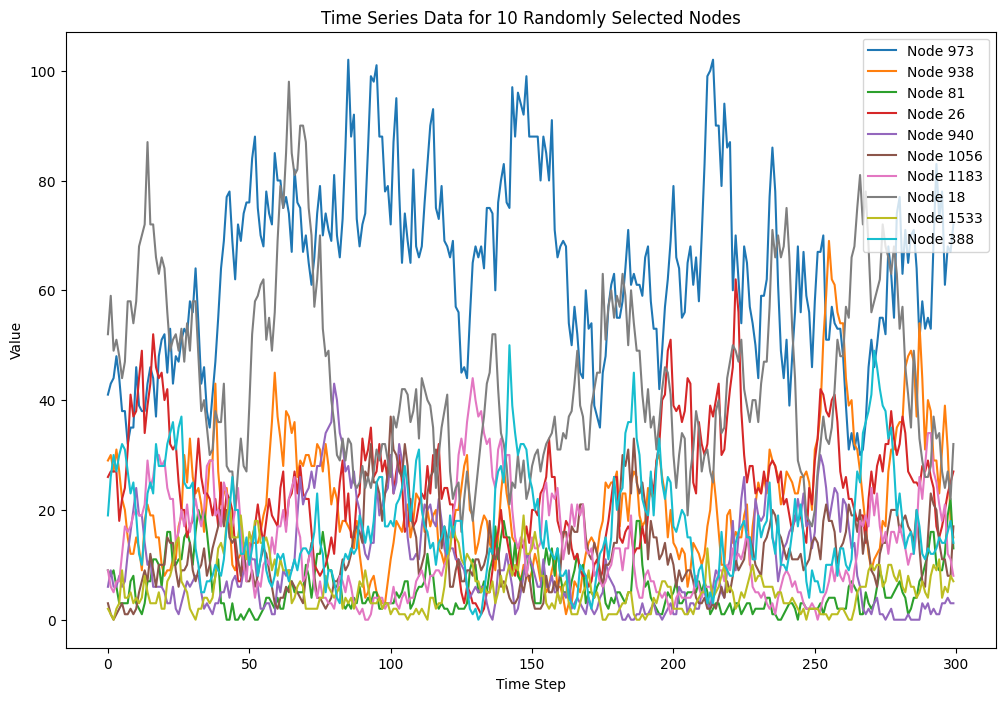

In [ ]:
import matplotlib.pyplot as plt


# Randomly select 10 nodes from the 2002 nodes
np.random.seed(16)  # For reproducibility
selected_nodes = np.random.choice(sim_data.shape[1], 10, replace=False)

# Extract the data for these 10 nodes
selected_data = sim_data[:, selected_nodes]

# Plot the extracted data
plt.figure(figsize=(12, 8))
time_steps = np.arange(sim_data.shape[0])

for i in range(selected_data.shape[1]):
    plt.plot(time_steps, selected_data[:, i], label=f'Node {selected_nodes[i]}')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Time Series Data for 10 Randomly Selected Nodes')
plt.legend(loc='upper right')
plt.show()

# NGNAR(1,[1]) with global alpha

In [ ]:
# Define parameters
n_steps = 200  # Adjust the number of steps as needed
ts_2001 = np.zeros((n_steps, 2002))

# Run the simulation for the specified number of steps
for t in range(1, n_steps):
    simulated_values = simulate_NGNAR(
        fmd_network,
        alpha_order=1,
        beta_order=[1],
        intercept=True,
        global_intercept=True,
        length=1,
        coefs=ng2.coefs
    )
    ts_2001[t, :] = ts_2001[t - 1, :] + simulated_values


In [ ]:
ts_2001.shape

(200, 2002)

In [ ]:
import pandas as pd
# Specify the file path
file_path = '/content/gdrive/MyDrive/NGNAR Net/farmsize.csv'

# Read the CSV file into a DataFrame
farmsize = pd.read_csv(file_path)

# Convert the DataFrame to a NumPy array
farmsize_numpy = farmsize.to_numpy()

In [ ]:
farmsize.shape

(1957, 1)

In [ ]:
# Define parameters
n_nodes = 2002
series_length = 200
farmsize_2001 = np.random.choice(farmsize.flatten(), size=2002, replace=True)
time_to_reach_farm_size = np.full(n_nodes, series_length)  # Default to series_length if farm size is never reached

for node in range(n_nodes):
    series = ts_2001[:, node]
    max_value = farmsize_2001[node]
    max_index = np.where(series >= max_value)[0]

    # Check if max_value is found in series
    if len(max_index) > 0:
        max_index = max_index[0]
        series[max_index + 1:] = max_value
        time_to_reach_farm_size[node] = max_index

    ts_2001[:series_length, node] = series

In [ ]:
node = 1
series = ts_2001[:series_length, node]
max_value = farmsize_2001[node]
max_index = np.where(series >= max_value)[0]


In [ ]:
time_to_reach_farm_size.shape

(2002,)

In [ ]:
# Calculate summary statistics for time to reach farm size
time_to_reach_farm_size_summary = {
    'mean': np.mean(time_to_reach_farm_size),
    'std': np.std(time_to_reach_farm_size),
    'min': np.min(time_to_reach_farm_size),
    '25%': np.percentile(time_to_reach_farm_size, 25),
    '50%': np.median(time_to_reach_farm_size),
    '75%': np.percentile(time_to_reach_farm_size, 75),
    'max': np.max(time_to_reach_farm_size)
}
# Print summary statistics
print("Summary Statistics for Time to Reach Farm Size:")
print(time_to_reach_farm_size_summary)

Summary Statistics for Time to Reach Farm Size:
{'mean': 102.22827172827172, 'std': 94.76545176941346, 'min': 1, '25%': 8.0, '50%': 36.0, '75%': 200.0, 'max': 200}


In [ ]:
# Calculate the average and standard deviation of the infection rate
infection_rates_2001 = np.diff(ts_2001, axis=0)
non_zero_infection_rates_2001 = infection_rates_2001[infection_rates_2001 != 0]

average_infection_rate_2001 = np.mean(non_zero_infection_rates_2001, axis=0)
std_infection_rate_2001 = np.std(non_zero_infection_rates_2001, axis=0)

# Summary statistics
infection_rate_2001_summary = {
    'mean_rate': np.mean(average_infection_rate_2001),
    'std_rate': np.mean(std_infection_rate_2001),
    'min_rate': np.min(average_infection_rate_2001),
    '25%_rate': np.percentile(average_infection_rate_2001, 25),
    '50%_rate': np.median(average_infection_rate_2001),
    '75%_rate': np.percentile(average_infection_rate_2001, 75),
    'max_rate': np.max(average_infection_rate_2001)
}

print("Summary Statistics for Infection Rates in 2001:")
print(infection_rate_2001_summary)

Summary Statistics for Infection Rates in 2001:
{'mean_rate': 24.313038459953006, 'std_rate': 17.500030664215704, 'min_rate': 24.313038459953006, '25%_rate': 24.313038459953006, '50%_rate': 24.313038459953006, '75%_rate': 24.313038459953006, 'max_rate': 24.313038459953006}


In [ ]:
non_zero_infection_rates_2001

array([ 37.,  18.,  60., ...,  56.,  45., -22.])

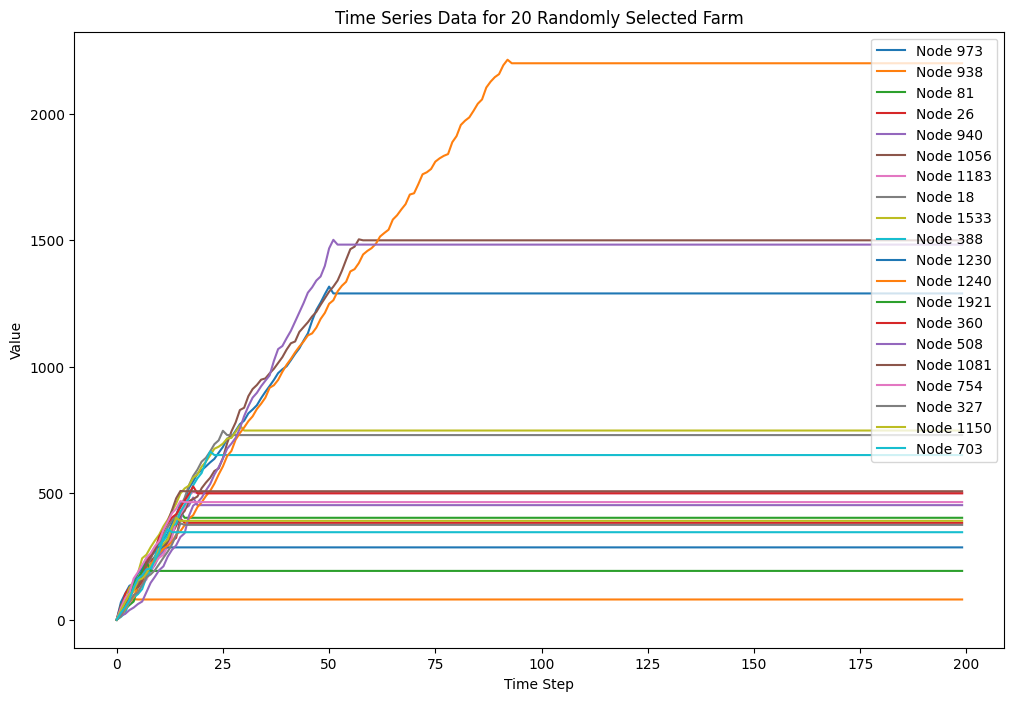

In [ ]:

# Randomly select 20 nodes from the 2002 nodes
np.random.seed(16)  # For reproducibility
selected_nodes = np.random.choice(ts_2001.shape[1], 20, replace=False)

# Extract the data for these 10 nodes
selected_data = ts_2001[:, selected_nodes]

# Plot the extracted data
plt.figure(figsize=(12, 8))
time_steps = np.arange(ts_2001.shape[0])

for i in range(selected_data.shape[1]):
    plt.plot(time_steps, selected_data[:, i], label=f'Node {selected_nodes[i]}')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Time Series Data for 20 Randomly Selected Farm')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Calculate maximum infection level for each node
max_number_2001 = np.max(ts_2001, axis=0)

# Calculate the time step at which the maximum infection level is reached for each node
time_to_max_number_2001 = np.argmax(ts_2001, axis=0)

time_to_reach_farm_size_summary = {
    'mean': np.mean(time_to_reach_farm_size),
    'std': np.std(time_to_reach_farm_size),
    'min': np.min(time_to_reach_farm_size),
    '25%': np.percentile(time_to_reach_farm_size, 25),
    '50%': np.median(time_to_reach_farm_size),
    '75%': np.percentile(time_to_reach_farm_size, 75),
    'max': np.max(time_to_reach_farm_size)
}

# Generate summary statistics
max_number_summary = {
    'mean': np.mean(max_number_2001),
    'std': np.std(max_number_2001),
    'min': np.min(max_number_2001),
    '25%': np.percentile(max_number_2001, 25),
    '50%': np.median(max_number_2001),
    '75%': np.percentile(max_number_2001, 75),
    'max': np.max(max_number_2001)
}

time_to_max_number_summary = {
    'mean': np.mean(time_to_max_number_2001),
    'std': np.std(time_to_max_number_2001),
    'min': np.min(time_to_max_number_2001),
    '25%': np.percentile(time_to_max_number_2001, 25),
    '50%': np.median(time_to_max_number_2001),
    '75%': np.percentile(time_to_max_number_2001, 75),
    'max': np.max(time_to_max_number_2001)
}

# Combine summary statistics into a dictionary
summary_stats_poi_2001 = {
    'max_number': max_number_summary,
    'time_to_max_number': time_to_max_number_summary
}

# Print summary statistics
print("Summary Statistics for Maximum Infection Number:")
print(max_number_summary)
print("\nSummary Statistics for Time to Maximum Infection Number:")
print(time_to_max_number_summary)

Summary Statistics for Maximum Infection Levels:
{'mean': 623.7092907092907, 'std': 686.3394266651169, 'min': 12.0, '25%': 212.25, '50%': 411.0, '75%': 761.0, 'max': 5590.0}

Summary Statistics for Time to Maximum Infection Levels:
{'mean': 22.378121878121878, 'std': 24.77707564245101, 'min': 1, '25%': 7.0, '50%': 15.0, '75%': 27.0, 'max': 199}


# NGNAR(1,[1]) without global alpha

In [ ]:
n_steps = 200  # Adjust the number of steps as needed
ts1_2001 = np.zeros((n_steps, 2002))

# Run the simulation for the specified number of steps
for t in range(1, n_steps):
    simulated_values = simulate_NGNAR(
        fmd_network,
        alpha_order=1,
        beta_order=[1],
        intercept=True,
        global_intercept=False,
        length=1,
        coefs=ng.coefs
    )
    ts1_2001[t, :] = ts1_2001[t - 1, :] + simulated_values

n_nodes = 2002
series_length = 200
farmsize_2001 = np.random.choice(farmsize.flatten(), size=2002, replace=True)
time_to_reach_farm_size1 = np.full(n_nodes, series_length)  # Default to series_length if farm size is never reached

for node in range(n_nodes):
    series = ts1_2001[:, node]
    max_value = farmsize_2001[node]
    max_index = np.where(series >= max_value)[0]

    # Check if max_value is found in series
    if len(max_index) > 0:
        max_index = max_index[0]
        series[max_index + 1:] = max_value
        time_to_reach_farm_size1[node] = max_index

    ts1_2001[:series_length, node] = series


In [ ]:
# Calculate summary statistics for time to reach farm size
time_to_reach_farm_size_summary1 = {
    'mean': np.mean(time_to_reach_farm_size1),
    'std': np.std(time_to_reach_farm_size1),
    'min': np.min(time_to_reach_farm_size1),
    '25%': np.percentile(time_to_reach_farm_size1, 25),
    '50%': np.median(time_to_reach_farm_size1),
    '75%': np.percentile(time_to_reach_farm_size1, 75),
    'max': np.max(time_to_reach_farm_size1)
}
# Print summary statistics
print("Summary Statistics for Time to Reach Farm Size:")
print(time_to_reach_farm_size_summary1)

Summary Statistics for Time to Reach Farm Size:
{'mean': 46.967032967032964, 'std': 55.87017483105149, 'min': 1, '25%': 8.0, '50%': 24.0, '75%': 62.0, 'max': 200}


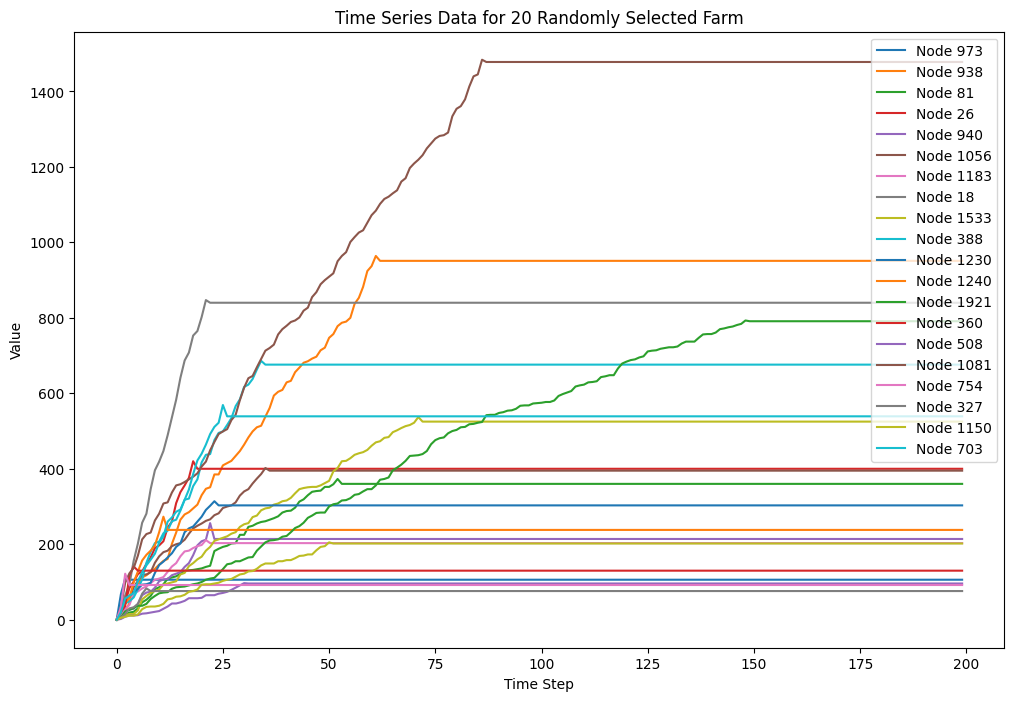

In [ ]:
# Randomly select 20 nodes from the 2002 nodes
np.random.seed(16)  # For reproducibility
selected_nodes = np.random.choice(ts1_2001.shape[1], 20, replace=False)

# Extract the data for these 10 nodes
selected_data = ts1_2001[:, selected_nodes]

# Plot the extracted data
plt.figure(figsize=(12, 8))
time_steps = np.arange(ts1_2001.shape[0])

for i in range(selected_data.shape[1]):
    plt.plot(time_steps, selected_data[:, i], label=f'Node {selected_nodes[i]}')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Time Series Data for 20 Randomly Selected Farm')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Calculate the average and standard deviation of the infection rate
infection_rates1_2001 = np.diff(ts1_2001, axis=0)
non_zero_infection_rates1_2001 = infection_rates1_2001[infection_rates1_2001 != 0]

average_infection_rate1_2001 = np.mean(non_zero_infection_rates1_2001, axis=0)
std_infection_rate1_2001 = np.std(non_zero_infection_rates1_2001, axis=0)

# Summary statistics
infection_rate1_2001_summary = {
    'mean_rate': np.mean(average_infection_rate1_2001),
    'std_rate': np.mean(std_infection_rate1_2001),
    'min_rate': np.min(average_infection_rate1_2001),
    '25%_rate': np.percentile(average_infection_rate1_2001, 25),
    '50%_rate': np.median(average_infection_rate1_2001),
    '75%_rate': np.percentile(average_infection_rate1_2001, 75),
    'max_rate': np.max(average_infection_rate1_2001)
}

print("Summary Statistics for Infection Rates1 in 2001:")
print(infection_rate1_2001_summary)

Summary Statistics for Infection Rates1 in 2001:
{'mean_rate': 12.142693619905982, 'std_rate': 17.744869925595683, 'min_rate': 12.142693619905982, '25%_rate': 12.142693619905982, '50%_rate': 12.142693619905982, '75%_rate': 12.142693619905982, 'max_rate': 12.142693619905982}


# 1967 Network time series simulation

## NGNAR(1,[1]) with global alpha

In [ ]:

with open('/content/gdrive/MyDrive/NGNAR Net/Edges_1967.json') as f:
    d = json.load(f)
    edges_1967 = {key: [x-1 for x in d[key]] for key in range(len(d))}

with open('/content/gdrive/MyDrive/NGNAR Net/Dists_1967.json') as f:
    d = json.load(f)
    for key in range(len(d)):
        if d[key] == {}:
            d[key] = []
    dists_1967 = {key: np.array(d[key]) for key in range(len(d))}

fmd_network_1967 = Network(edges_1967,dists_1967)

In [ ]:
# Define parameters
n_steps = 200  # Adjust the number of steps as needed
ts_1967 = np.zeros((n_steps, 4036))

# Run the simulation for the specified number of steps
for t in range(1, n_steps):
    simulated_values = simulate_NGNAR(
        fmd_network_1967,
        alpha_order=1,
        beta_order=[1],
        intercept=True,
        global_intercept=True,
        length=1,
        coefs=ng2.coefs
    )
    ts_1967[t, :] = ts_1967[t - 1, :] + simulated_values


In [ ]:
ts_1967.shape

(200, 4036)

In [ ]:
farmsize.shape

(1957, 1)

In [ ]:
# Specify the file path
file_path = '/content/gdrive/MyDrive/NGNAR Net/farmsize_1967.csv'

# Read the CSV file into a DataFrame
farmsize_1967 = pd.read_csv(file_path)

# Convert the DataFrame to a NumPy array
farmsize_1967 = farmsize_1967.to_numpy()

In [ ]:
farmsize_1967.shape

(4036, 1)

In [ ]:
# Calculate mean and standard deviation
mean_2001 = np.mean(farmsize)
sd_2001 = np.std(farmsize)

# Number of farms
n_farms = 2018

# Generate new farm sizes using a normal distribution
new_farm_sizes = np.random.normal(loc=mean_2001 / 2, scale=80, size=n_farms)

# Ensure new farm sizes are positive
new_farm_sizes = np.maximum(new_farm_sizes, 1)

# Round the farm sizes
new_farm_sizes = np.round(new_farm_sizes, 0)

# Sample initial infection sizes from the new farm sizes
farmsize_1967 = np.random.choice(new_farm_sizes, size=2018 * 2, replace=True)

# Print results to verify
print("Mean of Xiangfei.farmsize:", mean_2001)
print("Standard Deviation of Xiangfei.farmsize:", sd_2001)
print("New Farm Sizes:", new_farm_sizes)
print("1967 Farm Sizes:", farmsize_1967)

Mean of Xiangfei.farmsize: 612.0659172202351
Standard Deviation of Xiangfei.farmsize: 720.3865128513647
New Farm Sizes: [377. 271. 273. ... 250. 340. 226.]
1967 Farm Sizes: [295. 305. 279. ... 426. 202. 184.]


In [ ]:
np.mean(farmsize_1967)

302.81888007928643

In [ ]:
farmsize_1967.shape

(4036, 1)

In [ ]:
n_nodes = 4036
series_length = 200
time_to_reach_farm_size_1967 = np.full(n_nodes, series_length)  # Default to series_length if farm size is never reached

for node in range(n_nodes):
    series = ts_1967[:, node]
    max_value = farmsize_1967[node]
    max_index = np.where(series >= max_value)[0]

    # Check if max_value is found in series
    if len(max_index) > 0:
        max_index = max_index[0]
        series[max_index + 1:] = max_value
        time_to_reach_farm_size_1967[node] = max_index

    ts_1967[:series_length, node] = series

In [ ]:
# Calculate summary statistics for time to reach farm size
time_to_reach_farm_size_1967_summary = {
    'mean': np.mean(time_to_reach_farm_size_1967),
    'std': np.std(time_to_reach_farm_size_1967),
    'min': np.min(time_to_reach_farm_size_1967),
    '25%': np.percentile(time_to_reach_farm_size_1967, 25),
    '50%': np.median(time_to_reach_farm_size_1967),
    '75%': np.percentile(time_to_reach_farm_size_1967, 75),
    'max': np.max(time_to_reach_farm_size_1967)
}
# Print summary statistics
print("Summary Statistics for Time to Reach Farm Size in 1967:")
print(time_to_reach_farm_size_1967_summary)

Summary Statistics for Time to Reach Farm Size in 1967:
{'mean': 11.800297324083251, 'std': 13.34392063635195, 'min': 0, '25%': 4.0, '50%': 8.0, '75%': 15.0, 'max': 159}


In [ ]:
# Calculate the average and standard deviation of the infection rate
infection_rates_1967 = np.diff(ts_1967, axis=0)
non_zero_infection_rates_1967 = infection_rates_1967[infection_rates_1967 != 0]

average_infection_rate_1967 = np.mean(non_zero_infection_rates_1967, axis=0)
std_infection_rate_1967 = np.std(non_zero_infection_rates_1967, axis=0)

# Summary statistics
infection_rate_1967_summary = {
    'mean_rate': np.mean(average_infection_rate_1967),
    'std_rate': np.mean(std_infection_rate_1967),
    'min_rate': np.min(average_infection_rate_1967),
    '25%_rate': np.percentile(average_infection_rate_1967, 25),
    '50%_rate': np.median(average_infection_rate_1967),
    '75%_rate': np.percentile(average_infection_rate_1967, 75),
    'max_rate': np.max(average_infection_rate_1967)
}

print("Summary Statistics for Infection Rates in 1967:")
print(infection_rate_1967_summary)

Summary Statistics for Infection Rates in 1967:
{'mean_rate': 24.46730041711126, 'std_rate': 17.425524707645252, 'min_rate': 24.46730041711126, '25%_rate': 24.46730041711126, '50%_rate': 24.46730041711126, '75%_rate': 24.46730041711126, 'max_rate': 24.46730041711126}


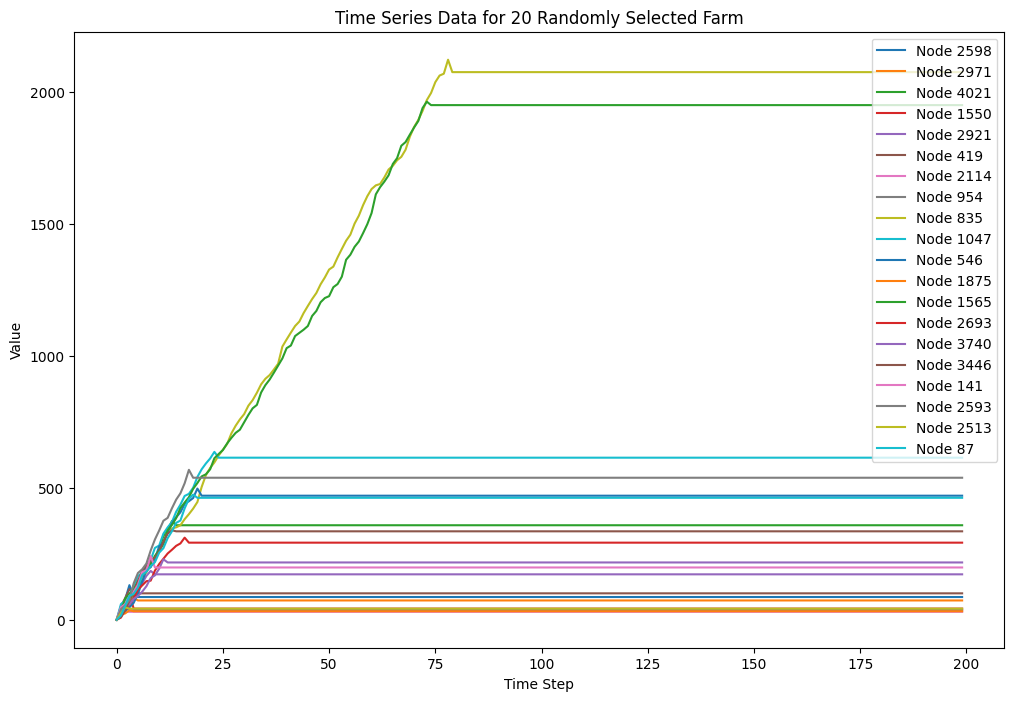

In [ ]:

# Randomly select 20 nodes from the 2002 nodes
np.random.seed(16)  # For reproducibility
selected_nodes = np.random.choice(ts_1967.shape[1], 20, replace=False)

# Extract the data for these 10 nodes
selected_data = ts_1967[:, selected_nodes]

# Plot the extracted data
plt.figure(figsize=(12, 8))
time_steps = np.arange(ts_1967.shape[0])

for i in range(selected_data.shape[1]):
    plt.plot(time_steps, selected_data[:, i], label=f'Node {selected_nodes[i]}')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Time Series Data for 20 Randomly Selected Farm')
plt.legend(loc='upper right')
plt.show()

## NGNAR(1,[1]) without global alpha

In [ ]:
n_steps = 200  # Adjust the number of steps as needed
ts1_1967 = np.zeros((n_steps, 4036))

# Run the simulation for the specified number of steps
for t in range(1, n_steps):
    simulated_values = simulate_NGNAR(
        fmd_network_1967,
        alpha_order=1,
        beta_order=[1],
        intercept=True,
        global_intercept=False,
        length=1,
        coefs=ng.coefs
    )
    ts1_1967[t, :] = ts1_1967[t - 1, :] + simulated_values


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2004 is different from 4038)

In [ ]:
n_steps = 200  # Adjust the number of steps as needed
ts1_1967 = np.zeros((n_steps, 4036))

# Run the simulation for the specified number of steps
for t in range(1, n_steps):
    simulated_values = simulate_NGNAR(
        fmd_network_1967,
        alpha_order=1,
        beta_order=[1],
        intercept=True,
        global_intercept=False,
        length=1,
        coefs=ng.coefs
    )
    ts1_1967[t, :] = ts1_1967[t - 1, :] + simulated_values

n_nodes = 4036
series_length = 200
time_to_reach_farm_size1_1967 = np.full(n_nodes, series_length)  # Default to series_length if farm size is never reached

for node in range(n_nodes):
    series = ts1_1967[:, node]
    max_value = farmsize_1967[node]
    max_index = np.where(series >= max_value)[0]

    # Check if max_value is found in series
    if len(max_index) > 0:
        max_index = max_index[0]
        series[max_index + 1:] = max_value
        time_to_reach_farm_size1_1967[node] = max_index

    ts1_1967[:series_length, node] = series

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2004 is different from 4038)